Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.patches as patches
import matplotlib.colors as mcolors 

## Defining Filter Coefficients

Setup:

In [2]:
# hardware inout (in µs):
step = 0.38
duration = 17.5

# load kernel:
filter_kernel = np.load('filter_data.npy')
samples = len(filter_kernel) # 300

original_time = np.linspace(0, duration, samples)

target_samples = int(duration / step) # 17.5 / 0.38 = 46
compressed_time = np.linspace(0, duration, target_samples) 

# interpolate to get kernel to length 17.5 µs:
interpolator = interp1d(original_time, filter_kernel, kind = 'cubic')
compressed_kernel = interpolator(compressed_time)

# get impulse response
impulse_response = np.diff(compressed_kernel, prepend = 0)

Impulse Response:

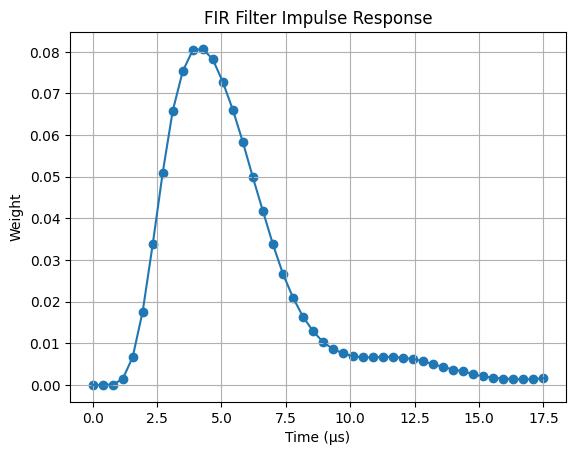

In [3]:
plt.scatter(compressed_time, impulse_response)
plt.plot(compressed_time, impulse_response)
plt.title("FIR Filter Impulse Response")
plt.xlabel("Time (μs)")
plt.ylabel("Weight")
plt.grid(True)
plt.show()

Filter Kernel:

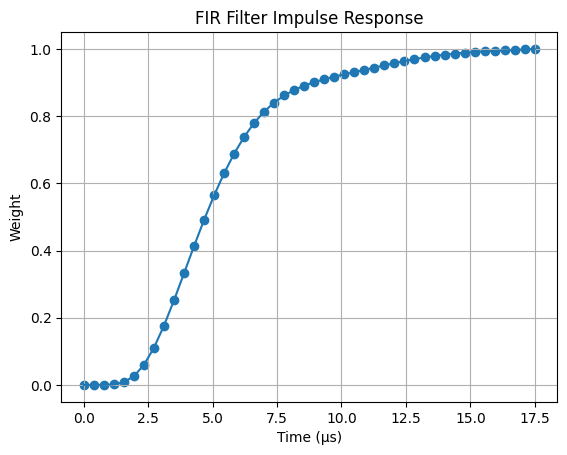

There are 46 coefficients


In [4]:
plt.scatter(compressed_time, compressed_kernel)
plt.plot(compressed_time, compressed_kernel)
plt.title("FIR Filter Impulse Response")
plt.xlabel("Time (μs)")
plt.ylabel("Weight")
plt.grid(True)
plt.show()

print(f'There are', len(compressed_kernel),'coefficients')

## Classes:

Filter Simulation Class:

In [60]:
class FilterSimulation():

    def __init__(self):
        self.filter_constant = 17.5 # hardware constraint on filter
        self.time_step = 0.38 # DAQ time step constraint

    def filter(self):
        # load kernel:
        filter_kernel = np.load('filter_data.npy')
        samples = len(filter_kernel) # 300

        original_time = np.linspace(0, self.filter_constant, samples)

        target_samples = int(self.filter_constant / self.time_step) # 17.5 / 0.38 = 46
        compressed_time = np.linspace(0, self.filter_constant, target_samples) 

        # interpolate to get kernel to length 17.5 µs:
        interpolator = interp1d(original_time, filter_kernel, kind = 'cubic')
        compressed_kernel = interpolator(compressed_time)

        # get impulse response
        impulse_response = np.diff(compressed_kernel, prepend = 0)
        
        return impulse_response

    def pre_setup(self, waveform):
        if waveform[0] != 0:
            waveform -= waveform[0]

        # define time (x-axis) and waveform (y-axis):
        total_time = len(waveform) * time_step # 51 * 0.38 = 19.38
        time_array = np.linspace(0, total_time, len(waveform)) # 0 to 19.38 with 51 samples
        waveform *= waveform_size # scale voltages as needed

        return time_array, waveform

    def setup(self, time_array, waveform, compress, pad):
        compressed_time = time_array / compress
        dense_waveform = np.interp(time_array, compressed_time, waveform)
        mask = 0
        for i in range(0, len(compressed_time)):
            if time_array[i] <= compressed_time[-1]:
                mask += 1
            else:
                break
        masked_waveform = dense_waveform[:mask]
        original = np.pad(masked_waveform, pad_width = pad, mode = 'edge')
        time = np.arange(len(original)) * time_step

        return time, original

    def convolution(self, waveform):
        impulse_response = self.filter()
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full')
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='cubic', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated_filtered):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated_filtered, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Filter Waveforms')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def scatter_plot(self, time, precompensated):
        plt.figure()
        plt.plot(time, precompensated, label = 'Full Plot', color = 'red')
        plt.scatter(time, precompensated, label = 'Scattered Plot', color = 'pink')
        plt.title('Precompensated Filtered Waveform')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def precompensation(self, waveform, reg, pad):
        impulse_response = self.filter()
        total_length = max(len(impulse_response), len(waveform)) + 2 * pad

        left_pad = pad
        right_pad_ir = max(0, total_length - len(impulse_response) - pad)
        right_pad_waveform = max(0, total_length - len(waveform) - pad)

        ir_padded = np.pad(impulse_response, (left_pad, right_pad_ir), mode='constant')
        waveform_padded = np.pad(waveform, (left_pad, right_pad_waveform), mode='constant', constant_values = waveform[-1])

        G = fft(ir_padded)
        h_t = waveform_padded
        h_w = fft(h_t)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg)
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase)

        f_w = h_w * regularized_G
        f_t = np.real(ifft(f_w))

        return f_t

    def trimming(self, original, precompensated, pad):
        for i in range(0, int(pad*0.5)):
            precompensated[i] = original[0]     
        for i in range(len(precompensated) - int(pad*0.5), len(precompensated)):
            precompensated[i] = original[-1]
        return precompensated

Optimize Class:

In [68]:
class Optimize():
    
    def __init__(self):
        self.padding_range = list(range(1, 41))
        self.reg_exponents = list(range(-6, 0))   
        self.reg_coeff = list(range(1, 8))
        self.compression_range = list(range(1, 10))
        
        self.lower_voltage_bound = -40
        self.upper_voltage_bound = 40
        self.time_step = 0.38

        self.alpha = 1.00 # <-- weight of max abs error (MUST be stronger)
        self.beta = 0.1 # <-- weight of padding
        self.gamma = 0.01 # <-- weight of compression

    def optimizer(self, time_array, waveform):
        best_penalty = float('inf')
        best_params = (None, None, None, None, None) # compression, padding, reg_strength, penalty, bounds
        all_best_params = []
        reg_array = []
        
        # generate all possibilities:
        for k, compress in enumerate(self.compression_range):
            for i, pad in enumerate(self.padding_range):
                for j, reg in enumerate(self.reg_exponents):
                    for l, coeff in enumerate(self.reg_coeff):
                        reg_strength = coeff * 10 ** reg

                        time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

                        # filtering:
                        precompensated = FilterSimulation().precompensation(original, reg_strength, pad)
                        precompensated = precompensated[:len(original)]
                        precompensated = FilterSimulation().trimming(original, precompensated, pad)
                        precompensated_filtered = FilterSimulation().convolution(precompensated)
                        shift_p = np.arange(len(precompensated_filtered)) * self.time_step
                        precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)
                        
                        # results:
                        error = np.max(np.abs(original - precompensated_filtered))
                        penalty = error #self.alpha * error + self.beta * pad - self.gamma * compress

                        # print(f'Pad: {pad}, Compress: {compress}, Reg: {reg_strength}, Error: {error}')
                        
                        if np.max(precompensated) > self.upper_voltage_bound or np.min(precompensated) < self.lower_voltage_bound:
                            bounds = 1
                        else:
                            bounds = 0

                        if bounds == 0:
                            if penalty < best_penalty:
                                best_penalty = penalty
                                best_params = (compress, pad, reg_strength, penalty, bounds)
                                all_best_params.append(best_params)

                        if len(reg_array) < (len(self.reg_coeff) * len(self.reg_exponents)):
                            reg_array.append(reg_strength)

        valid_results = [res for res in all_best_params if res[4] == 0]
        if not valid_results:
            print("No valid results found within bounds! Returning least-penalty violating case.")
            best_params = min(all_best_params, key = lambda x: x[3])
        else:
            best_params = min(valid_results, key = lambda x: x[3])
        
        return best_params, reg_array
    
    def get_grids(self, time_array, waveform, best_params):
        compression_grids = {}
        compress = best_params[0]

        error_grid = np.full((len(self.padding_range), len(self.reg_exponents) * len(self.reg_coeff)), np.nan)
        bounds_grid = np.full((len(self.padding_range), len(self.reg_exponents) * len(self.reg_coeff)), np.nan)
        
        for i, pad in enumerate(self.padding_range):
            reg_index = 0
            for j, reg in enumerate(self.reg_exponents):
                for l, coeff in enumerate(self.reg_coeff):
                    reg_strength = coeff * 10 ** reg

                    time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

                    # filtering:
                    precompensated = FilterSimulation().precompensation(original, reg_strength, pad)
                    precompensated = precompensated[:len(original)]
                    precompensated = FilterSimulation().trimming(original, precompensated, pad)
                    precompensated_filtered = FilterSimulation().convolution(precompensated)
                    shift_p = np.arange(len(precompensated_filtered)) * self.time_step
                    precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

                    # results:
                    error = np.max(np.abs(original - precompensated_filtered))
                    penalty = self.alpha * error + self.beta * pad - self.gamma * compress

                    if np.max(precompensated) > self.upper_voltage_bound or np.min(precompensated) < self.lower_voltage_bound:
                        bounds = 1
                    else:
                        bounds = 0

                    error_grid[i, reg_index] = error
                    bounds_grid[i, reg_index] = bounds
                    reg_index += 1

        compression_grids[compress] = (error_grid.copy(), bounds_grid.copy())
        return compression_grids

                        
    def heatmap(self, best_params, compression_grids, reg_array):
        compress = best_params[0]
        pad = best_params[1]
        reg = best_params[2]
        error_grid, bounds_grid = compression_grids[compress]

        plt.figure(figsize = (12, 7))
        
        cmap = sns.color_palette("coolwarm", as_cmap = True)
        ax = sns.heatmap(
            error_grid,
            yticklabels = self.padding_range[::10],  # compression values
            cmap = cmap,
            cbar_kws = {'label': 'Error (in V)'},
            annot = False, # set to true for values displayed on each cell
            fmt = '.2e', # scientific notation format for annotations
        )

        # gray overlay where bounds = 1:
        overlay = np.where(bounds_grid == 1, 1, np.nan)  # 1 where out of bounds, NaN elsewhere
        sns.heatmap(
            overlay,
            mask = np.isnan(overlay),
            cmap = mcolors.ListedColormap([(0.5, 0.5, 0.5, 0.8)]),  # Gray with alpha=0.8
            cbar = False,
            ax = ax
        )

        plt.title(f'Heatmap at Compression x{compress}')
        plt.xlabel('Regularization Strength')
        plt.ylabel('Padding Samples')

        n_yticks = 7
        ytick_positions = np.linspace(0, len(self.padding_range) - 1, n_yticks, dtype = int)
        plt.yticks(ytick_positions, [self.padding_range[i] for i in ytick_positions])
        
        n_xticks = 12
        xtick_positions = np.linspace(0, len(reg_array) - 1, n_xticks, dtype = int)
        labels = [f'{coeff}e{exponent}' for exponent in self.reg_exponents for coeff in self.reg_coeff]
        selected_labels = [labels[i] for i in xtick_positions]
        plt.xticks(xtick_positions, selected_labels, rotation = 45)

        ax.grid(False)
        rect = patches.Rectangle((reg_array.index(reg), self.padding_range.index(pad)), 1, 1, fill = False, edgecolor = 'gold', lw = 3)
        ax.add_patch(rect)
        plt.tight_layout()
        plt.show()

    def error_plotter(self, time, original, precompensated_filtered, best_params):
        rmse = np.sqrt(mean_squared_error(original, precompensated_filtered)) # average error across all points (precompensation is off by about -- volts)
        pointwise_error = np.abs(original - precompensated_filtered) # worst deviation point in the waveform 

        compress = best_params[0]
        pad = best_params[1]
        reg = best_params[2]
        best_penalty = best_params[3]
        
        print('----------------------------------------------------')
        print(f'The best padding is:', pad)
        print(f'The best regularization is: {reg:.0e}')
        print(f'The best compression is: {compress}')
        print(f'The best penalty is: {best_penalty}')
        print(f"Root Mean Squared Error (RMSE): {rmse:.3f} V")
        print(f"Max Absolute Error: {np.max(pointwise_error):.3f} V")

        # absolute error over time:
        plt.plot(time, pointwise_error, color='red', label='|Original - Precompensated Filtered|')
        plt.title('Error between Original and Precompensated Filtered Signal')
        plt.xlabel('Time in µs')
        plt.ylabel('Absolute Error (V)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def tradeoff_plot(self, time_array, waveform, best_params):
        error_array = []
        compression_array = []
        pad = best_params[1]
        reg = best_params[2]
        
        for k, compress in enumerate(self.compression_range):
            time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

            # filtering:
            precompensated = FilterSimulation().precompensation(original, reg, pad)
            precompensated = precompensated[:len(original)]
            precompensated = FilterSimulation().trimming(original, precompensated, pad)
            precompensated_filtered = FilterSimulation().convolution(precompensated)
            shift_p = np.arange(len(precompensated_filtered)) * self.time_step
            precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)
            
            # results:
            error = np.max(np.abs(original - precompensated_filtered))
            compression_array.append(compress)
            error_array.append(error)

        plt.plot(compression_array, error_array)
        plt.xlabel("Compression")
        plt.ylabel("Max Absolute Error")
        plt.title("Compression vs. Max Error")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Transport Ramp Usage

## Neighboring Segments Use Case

Input Values:

In [8]:
waveform_size = 6 # volts
time_step = 0.38 # DAQ lower limit

# waveform data:
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0])

Pre-Filter Setup:

(Original)

There are 51 points total.


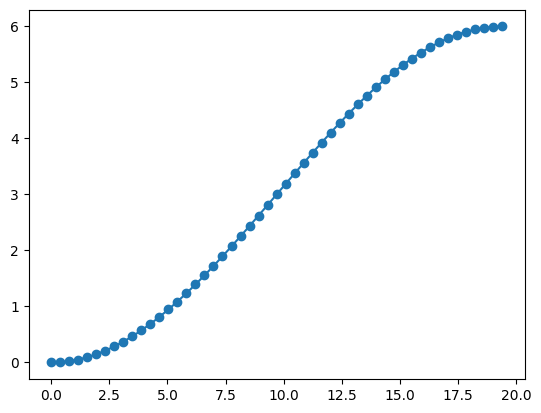

In [9]:
# make waveform start at 0:
if waveform[0] != 0:
    waveform -= waveform[0]

# define time (x-axis) and waveform (y-axis):
total_time = len(waveform) * time_step # 51 * 0.38 = 19.38
time_array = np.linspace(0, total_time, len(waveform)) # 0 to 19.38 with 51 samples
waveform *= waveform_size # scale voltages as needed

plt.scatter(time_array, waveform)
plt.plot(time_array, waveform)

print(f'There are', len(waveform),'points total.')

Setup:

In [30]:
# input data:
waveform_size = 6 # volts
time_step = 0.38 # DAQ lower limit

# waveform data:
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0])
time_array, waveform = FilterSimulation().pre_setup(waveform)

Compress Waveform:

In [ ]:
# compress waveform:
compressed_time = time_array / compress #19.38 / 2 = 9.69 (new time axis for compression = 2)
dense_waveform = np.interp(time_array, compressed_time, waveform)

print(f'Before masking, the waveform length is:', len(masked_waveform))

# cut off excess from interpolation:
mask = 0
for i in range(0, len(compressed_time)):
    if time_array[i] <= compressed_time[-1]:
        mask += 1
    else:
        break
masked_waveform = dense_waveform[:mask]

print(f'The waveform length is:', len(masked_waveform))

plt.plot(compressed_time, masked_waveform)
plt.title(f'Compressed Waveform and Time (by x{compress})')
plt.show()

Pad Waveform:

In [ ]:
# pad waveform:
original = np.pad(masked_waveform, pad_width = pad, mode = 'edge')
time = np.arange(len(original)) * time_step

print(f'The waveform length is:', len(original))

plt.plot(time, original)
plt.title(f'Padded Waveform and Time (by x{pad})')
plt.show()

Optimize:

In [31]:
best_params, reg_array = Optimize().optimizer(time_array, waveform)

compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

Setup Waveform for Filtering:

In [32]:
# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

Begin Filter Simulation:

In [33]:
# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

Output Results:

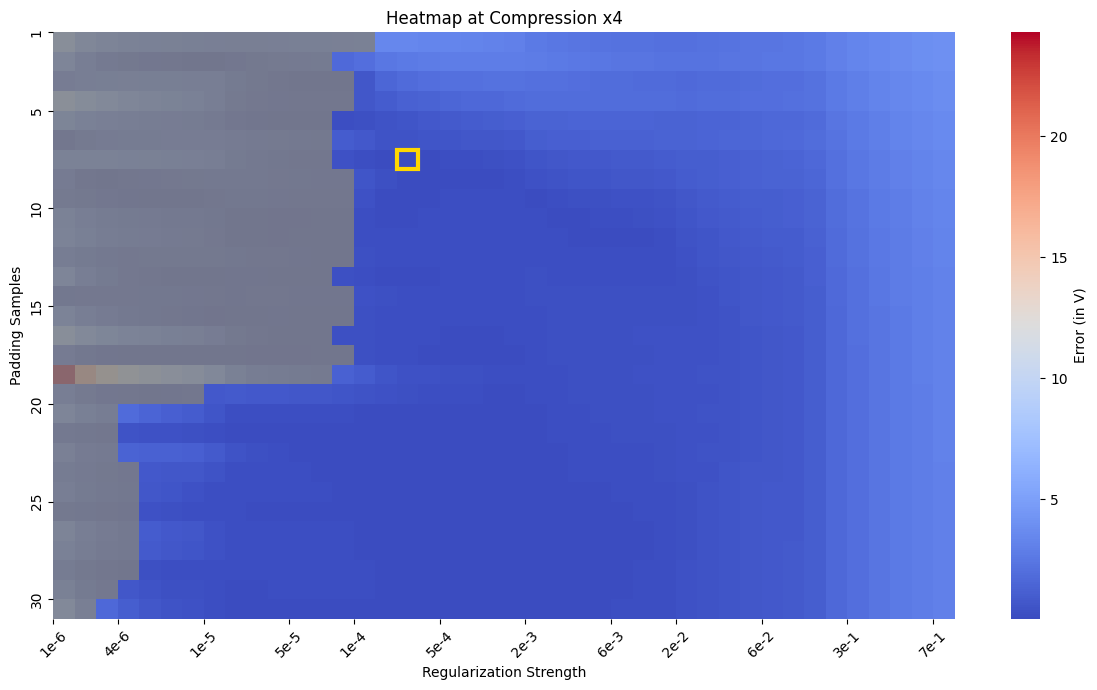

In [34]:
# plot heatmap:
compression_grids = Optimize().get_grids(time_array, waveform, best_params)
Optimize().heatmap(best_params, compression_grids, reg_array)

----------------------------------------------------
The best padding is: 7
The best regularization is: 3e-04
The best compression is: 4
The best penalty is: 0.13624708047500952
Root Mean Squared Error (RMSE): 0.062 V
Max Absolute Error: 0.106 V


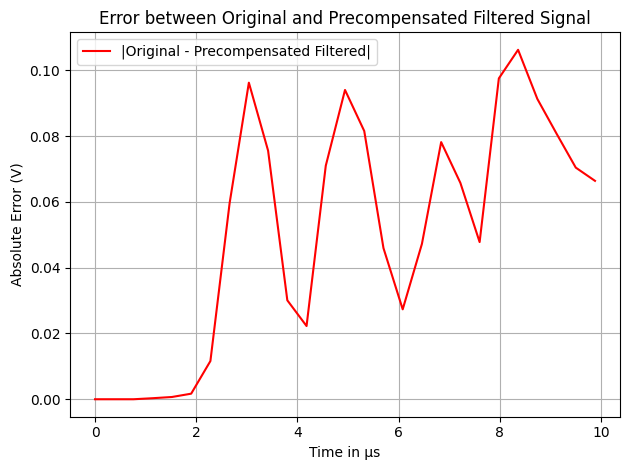

In [35]:
# plot errors:
Optimize().error_plotter(time, original, precompensated_filtered, best_params) # <-- error checker

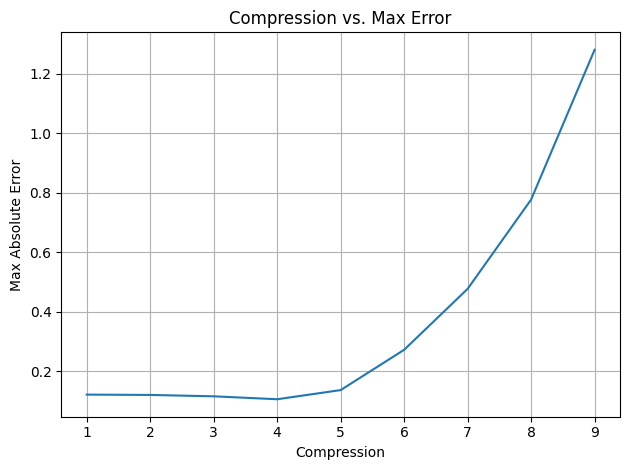

In [36]:
# plot error vs compression tradeoff:
Optimize().tradeoff_plot(time_array, waveform, best_params)

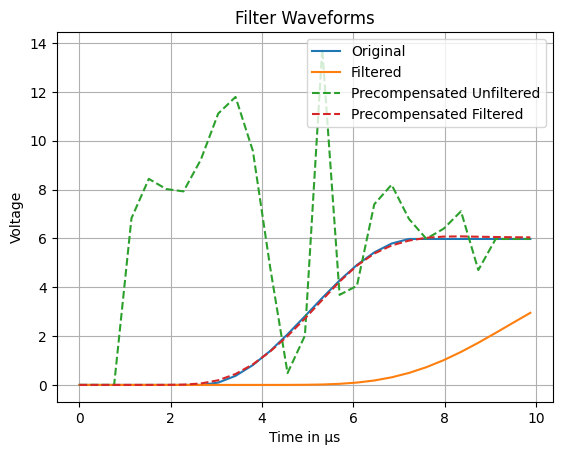

In [37]:
# plot all waveforms:
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

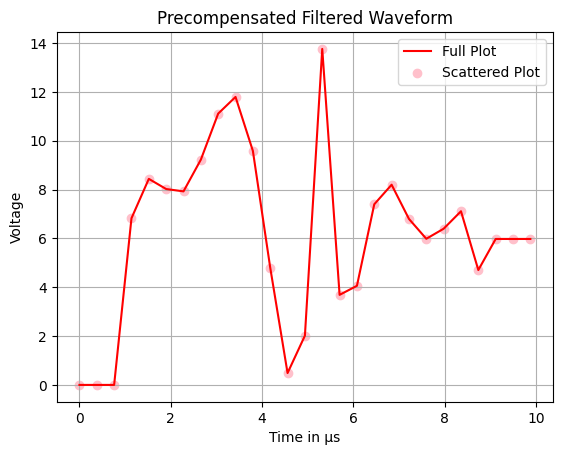

There are 27 points total.


In [38]:
# plot DAQ steps:
FilterSimulation().scatter_plot(time, precompensated)
print(f'There are', len(original),'points total.')

Uninterrupted Example Usage:

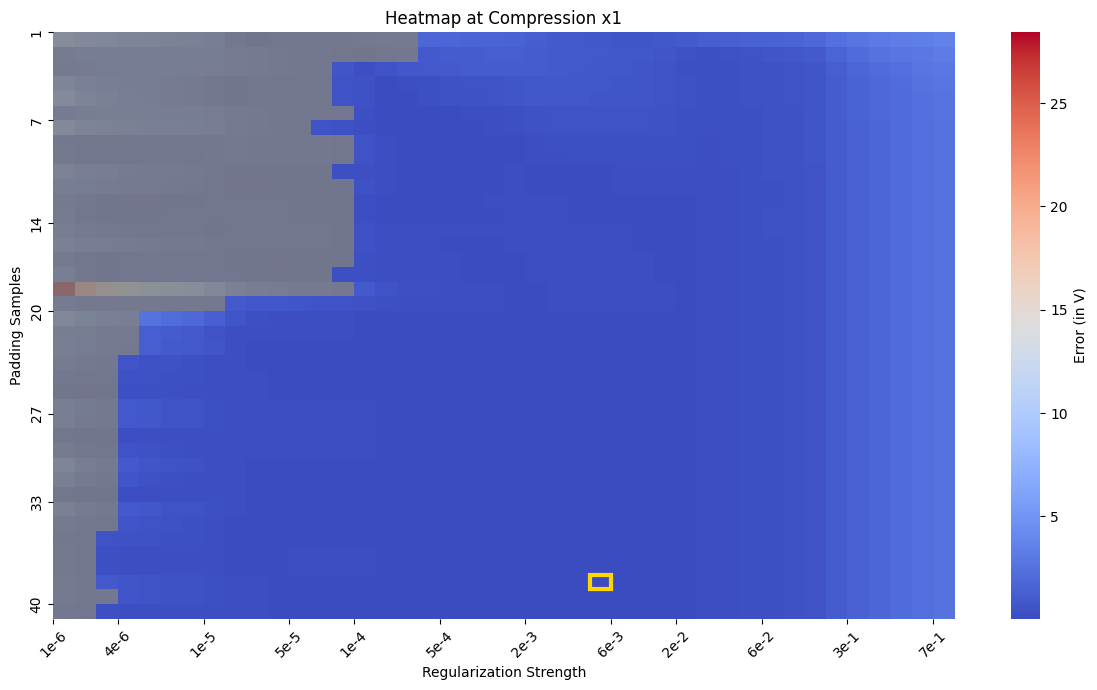

----------------------------------------------------
The best padding is: 38
The best regularization is: 5e-03
The best compression is: 1
The best penalty is: 0.03887719080212384
Root Mean Squared Error (RMSE): 0.021 V
Max Absolute Error: 0.039 V


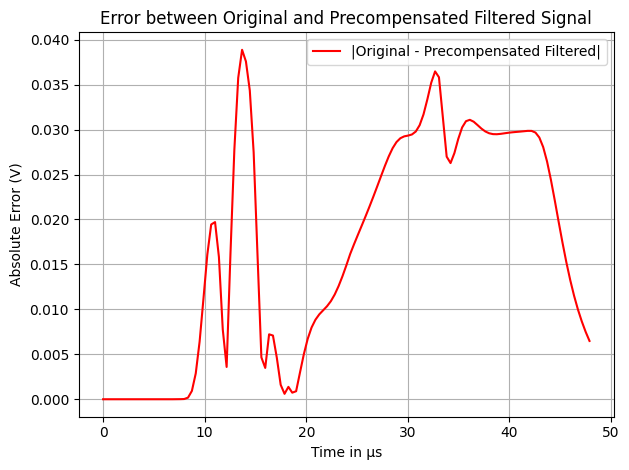

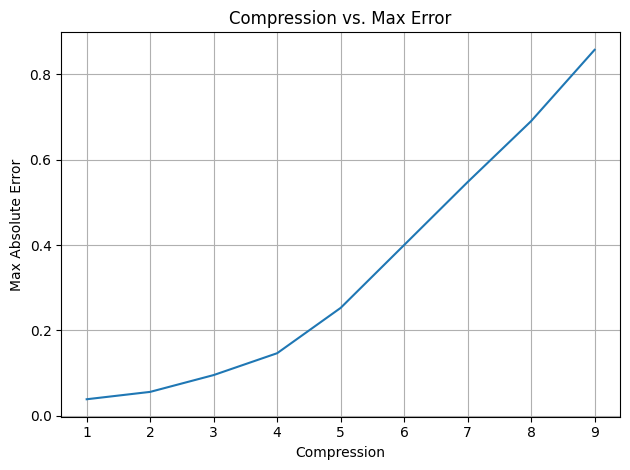

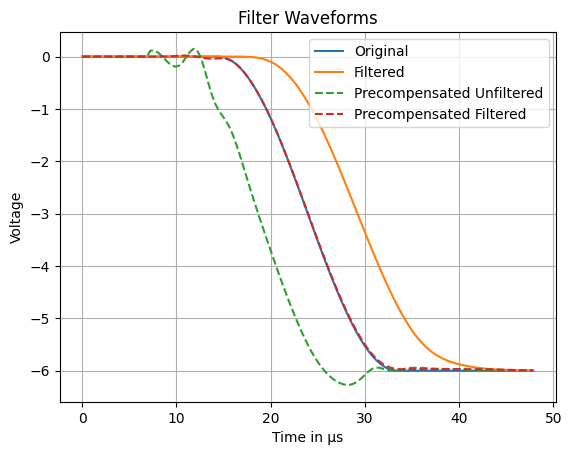

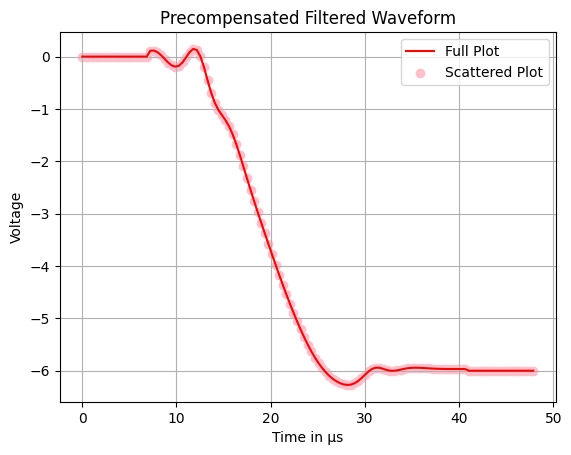

There are 127 points total.


In [69]:
# input data:
waveform_size = 6 # volts
time_step = 0.38 # DAQ lower limit

# waveform data:
waveform = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1]) + 1

time_array, waveform = FilterSimulation().pre_setup(waveform)

# optimization:
best_params, reg_array = Optimize().optimizer(time_array, waveform)
compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# results:
compression_grids = Optimize().get_grids(time_array, waveform, best_params)
Optimize().heatmap(best_params, compression_grids, reg_array)
Optimize().error_plotter(time, original, precompensated_filtered, best_params) # <-- error checker
Optimize().tradeoff_plot(time_array, waveform, best_params)
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)
FilterSimulation().scatter_plot(time, precompensated)
print(f'There are', len(original),'points total.')

## Non-Neighboring Segments

Example Usage:

In [77]:
# input values:
waveform_size = -6 # volts
time_step = 0.38 # DAQ lower limit

# waveform data:
time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform_1_1 = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1
waveform_1_2 = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1]) + 1

waveform = np.concatenate((waveform_1_1, waveform_1_2)) #modify this to concatenate multiple waveforms
new_time_array = time_array + time_array[-1] + time_array[1] - time_array[0]
time_array = np.concatenate((time_array, new_time_array))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


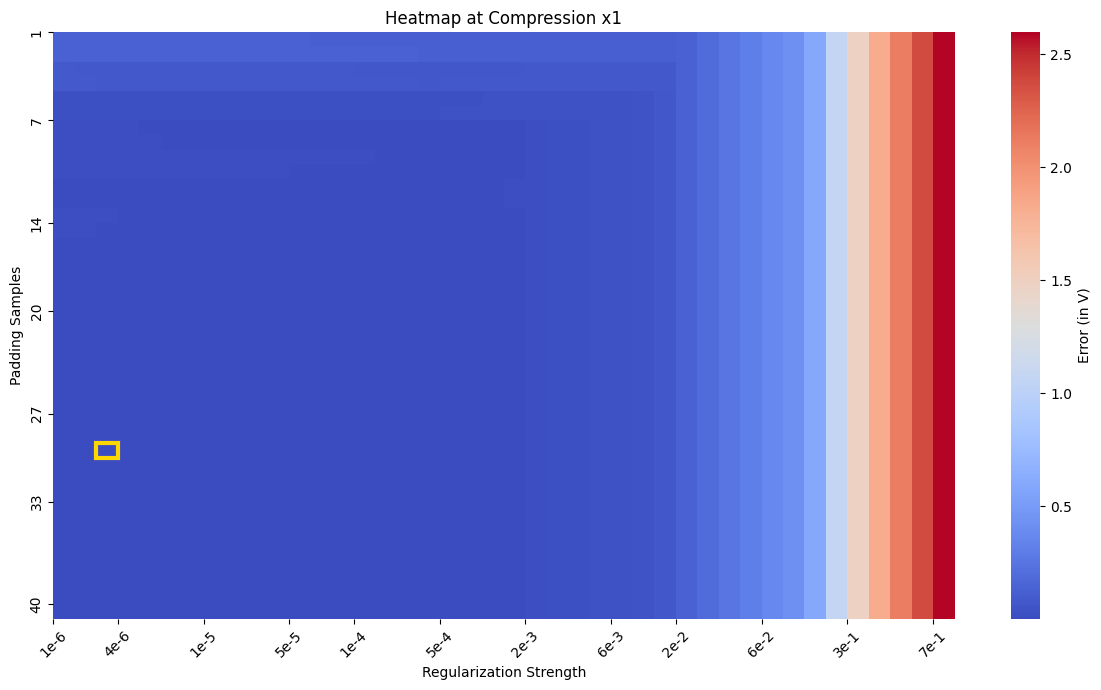

----------------------------------------------------
The best padding is: 29
The best regularization is: 3e-06
The best compression is: 1
The best penalty is: 0.0007332550155432255
Root Mean Squared Error (RMSE): 0.000 V
Max Absolute Error: 0.001 V


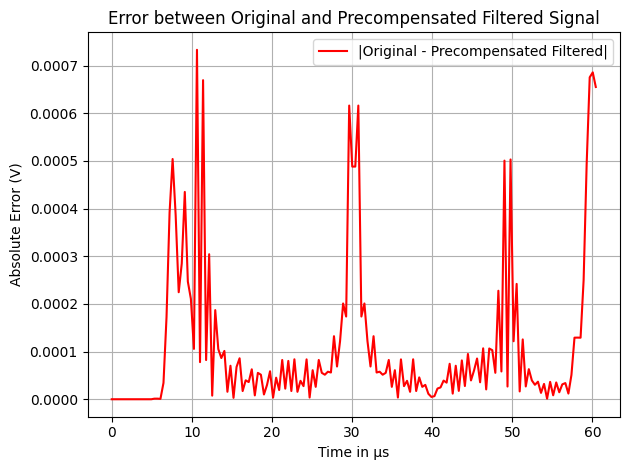

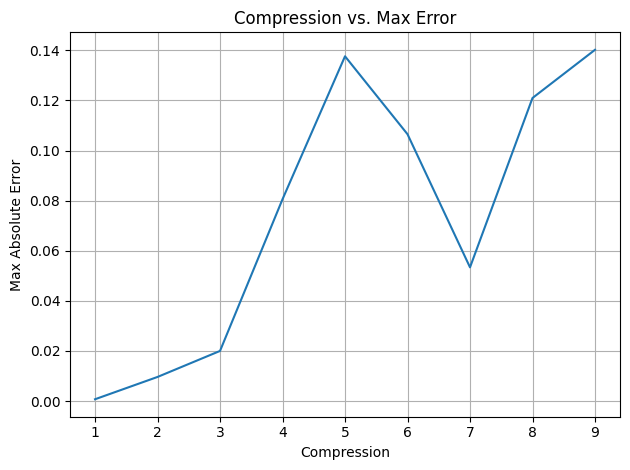

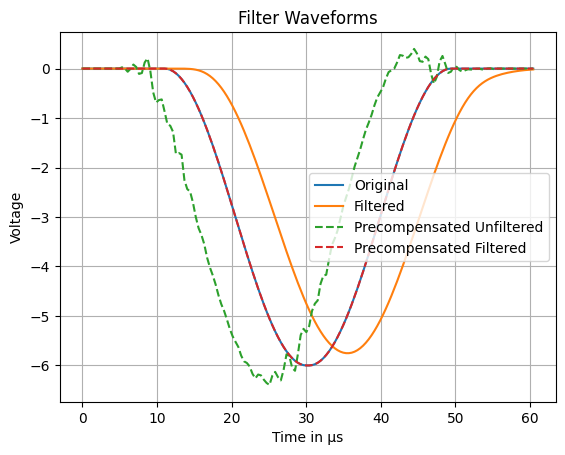

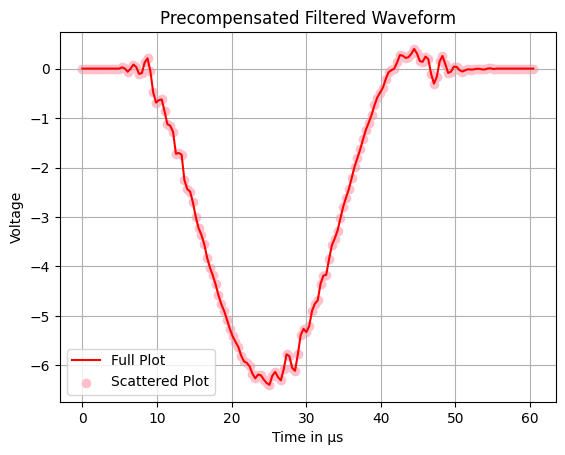

There are 160 points total.


In [78]:
time_array, waveform = FilterSimulation().pre_setup(waveform)

# optimization:
best_params, reg_array = Optimize().optimizer(time_array, waveform)
compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# results:
compression_grids = Optimize().get_grids(time_array, waveform, best_params)
Optimize().heatmap(best_params, compression_grids, reg_array)
Optimize().error_plotter(time, original, precompensated_filtered, best_params) # <-- error checker
Optimize().tradeoff_plot(time_array, waveform, best_params)
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)
FilterSimulation().scatter_plot(time, precompensated)
print(f'There are', len(original),'points total.')

In [ ]:

compressed_time = time_array / compress


time = np.arange(len(original)) * time_step




# dense_waveform = np.interp(time_array, compressed_time, waveform)
# mask = 0
# for i in range(0, len(compressed_time)):
#     if time_array[i] <= compressed_time[-1]:
#         mask += 1
#     else:
#         break
# masked_waveform = dense_waveform[:mask]
original = np.pad(masked_waveform, pad_width = pad, mode = 'edge')
time = np.arange(len(original)) * time_step

time_length = list(range(len(time) * -10, len(time) * 10))

# Swap Ramp Usage

Import Data:

In [87]:
import numpy as np
import matplotlib.pyplot as plt

time_list, waveform_1_list, waveform_2_list, waveform_3_list = [], [], [], []

with open("swap.dat", "r") as f:
    lines = f.readlines()

for line in lines:
    # Split using any amount of whitespace
    parts = line.strip().split()
    
    if len(parts) >= 4:
        time_list.append(float(parts[0]))
        waveform_1_list.append(float(parts[1]))
        waveform_2_list.append(float(parts[2]))
        waveform_3_list.append(float(parts[3]))

time_array = np.array(time_list)
waveform_1_2 = np.array(waveform_1_list)
waveform_2_2 = np.array(waveform_2_list)
waveform_3_2 = np.array(waveform_3_list)

Visualize Swap Waveforms:

time_array: [0.    0.001 0.002 ... 0.998 0.999 1.   ]
waveform_1: [-5.99999982 -5.99999982 -5.99999983 ... -5.99999983 -5.99999982
 -5.99999982]
waveform_2: [ 0.00168629  0.00154219  0.00110991 ... -0.00111024 -0.00154255
 -0.00168665]
waveform_3: [-0.00168665 -0.00154255 -0.00111024 ...  0.00110991  0.00154219
  0.00168629]


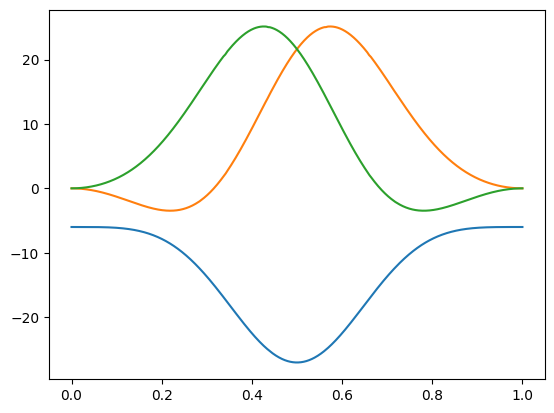

In [88]:
print("time_array:", time_array)
print("waveform_1:", waveform_1_2)
print("waveform_2:", waveform_2_2)
print("waveform_3:", waveform_3_2)

plt.plot(time_array, waveform_1_2)
plt.plot(time_array, waveform_2_2)
plt.plot(time_array, waveform_3_2)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


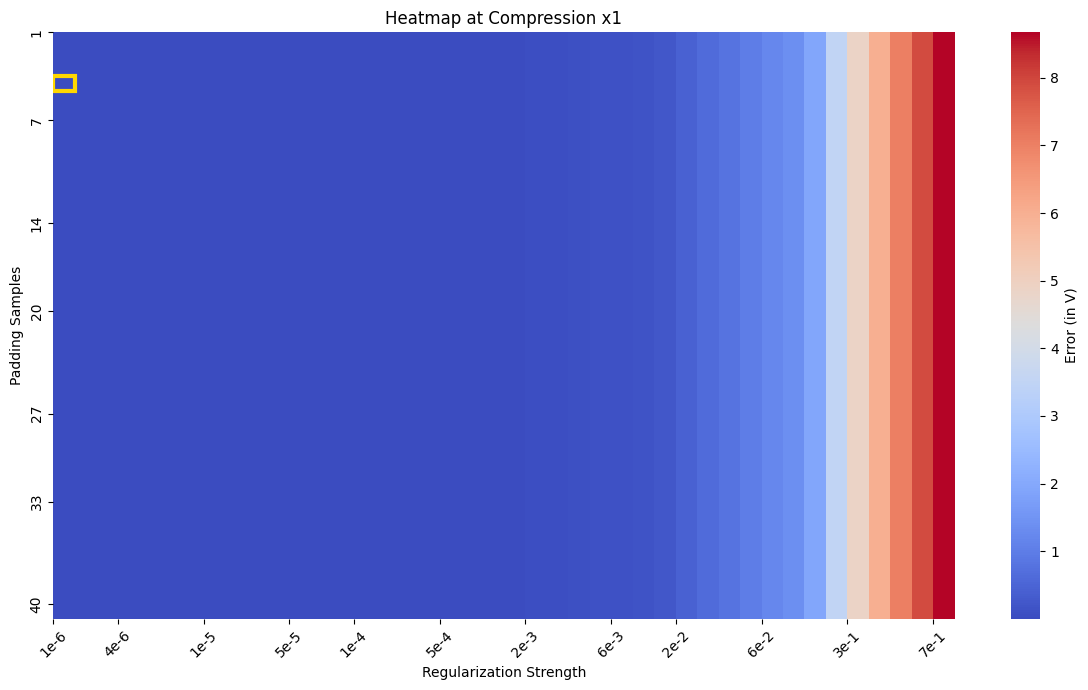

----------------------------------------------------
The best padding is: 4
The best regularization is: 1e-06
The best compression is: 1
The best penalty is: 0.00011960520756204573
Root Mean Squared Error (RMSE): 0.000 V
Max Absolute Error: 0.000 V


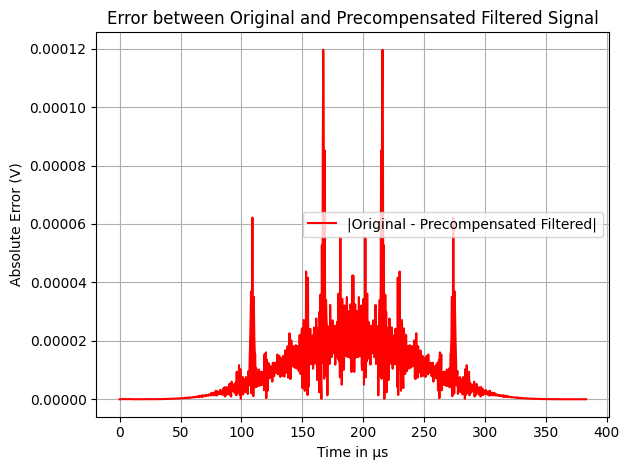

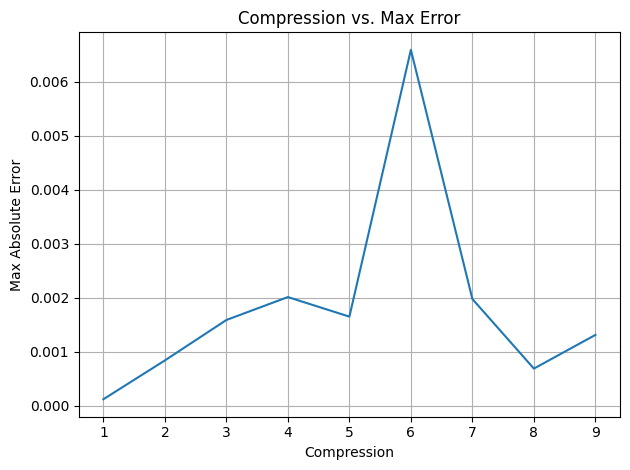

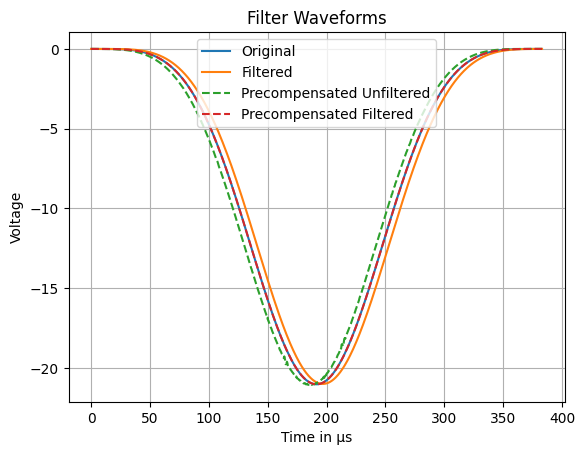

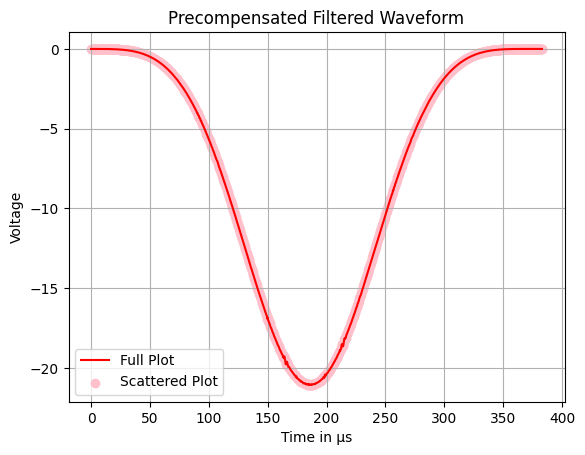

There are 1009 points total.


In [89]:
# input data:
waveform_size = 1 # not already normalized
time_step = 0.38 # DAQ lower limit

# waveform data:
waveform = waveform_1_2
time_array, waveform = FilterSimulation().pre_setup(waveform)

# optimization:
best_params, reg_array = Optimize().optimizer(time_array, waveform)
compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# results:
compression_grids = Optimize().get_grids(time_array, waveform, best_params)
Optimize().heatmap(best_params, compression_grids, reg_array)
Optimize().error_plotter(time, original, precompensated_filtered, best_params) # <-- error checker
Optimize().tradeoff_plot(time_array, waveform, best_params)
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)
FilterSimulation().scatter_plot(time, precompensated)
print(f'There are', len(original),'points total.')

# Spline Implementation